In [7]:
# coding:utf-8
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
import numpy as np
import random
import chainer
from chainer import Function, Variable, optimizers
from chainer import Link, Chain
import chainer.functions as F
import chainer.links as L
import copy
"""
MAZE = [[-1,-1,-1,-1,-1,-1,-1,-1,-1,-1],
        [-1, 0, 0, 0, 0, 0, 0, 0, 0,-1],
        [-1,-1,-1,-1,-1, 0,-1,-1, 0,-1],
        [-1,-1, 0, 0, 0, 0, 0,-1, 0,-1],
        [-1, 0,-1,-1,-1,-1,-1,-1, 0,-1],
        [-1, 0,-1, 0, 0, 0, 0, 0, 0,-1],
        [-1, 0,-1,-1,-1,-1,-1,-1, 0,-1],
        [-1, 0, 0, 0, 0, 0, 0, 0, 0,-1],
        [-1,-1, 0,-1,-1,-1,-1,-1,-9,-1],
        [-1,-1, 0, 0, 0, 0, 0, 0, 1,-1],
        [-1,-1,-1,-1,-1,-1,-1,-1,-1,-1]]
"""
MAZE = [[-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1],
        [-1, 0, 0, 0, 0, 0, 0, 0, 0,-1,-1,-1],
        [-1,-1,-1,-1,-1, 0,-1,-1, 0,-1,-1,-1],
        [-1,-1, 0, 0, 0, 0, 0,-1, 0,-1,-1,-1],
        [-1, 0,-1,-1,-1,-1,-1,-1, 0,-1,-1,-1],
        [-1, 0, 0, 0, 0, 0, 0, 0 ,0,-1,-1,-1],
        [-1, 0,-1,-1,-1,-1,-1,-1, 0,-1,-1,-1],
        [ 0, 0, 0, 0, 0, 0, 0, 0, 0,-1,-1,-1],
        [ 0,-1, 0,-1,-1,-1,-1,-1,-1,-1,-1,-1],
        [ 0,-1, 0, 0, 0, 0, 0, 0, 0,-1,-1,-1],
        [ 0,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1],
        [ 0,-1, 0, 0, 0, 0,-1, 0, 0, 0, 1,-1],
        [ 0, 0, 0,-1,-1, 0, 0, 0,-1,-1,-1,-1]]
START  = (1, 1)
ACTION = [(-1, 0), (1, 0), (0, -1), (0, 1)] # [上, 下, 左, 右]
EPOCH  = 500
RESULT = []
NUM_IN   = (len(MAZE)+1) * (len(MAZE[0])+1)
NUM_HID1 = 1000
NUM_HID2 = 500
NUM_HID3 = 250
NUM_OUT  = 4
BATCH_SIZE = 100
ALPH   = 0.1

GAMMA  = np.array([0.99 for i in range(BATCH_SIZE)], np.float32)

def deep_q_learn(q_network, target_network, records):
    file = open("/Users/chan-p/Desktop/action.txt", "w")
    action_check_file = open("/Users/chan-p/Desktop/action_check.txt", "w")
    result_list  = []
    next_records = []
    best_records = []
    state_index  = init_index()
    EPSIL  = 0.15
    state_vecs, actions, rewords ,next_state_vecs, terminals, next_states, now_states= translate(records)
    for epoch in range(EPOCH):
        # EPSIL = decay_EPSIL(epoch, EPSIL)
        state_vec = init_state_vec()
        now_state = START
        state_vec[state_index[START]] = 1
        record_write(file, 0, 0, 3)
        while True:
            # 状態sをDNN用にベクトル化
            state_vec = get_state_vec(state_vec)
            # 状態sをDNNの入力として状態sにおける各行動aの行動価値を算出：Q(s,a)
            # 方策：e-greedy
            action, q_max, action_list = policy_egreedy(state_vec, q_network, EPSIL)
            # 次の状態s'を決定
            next_state = get_next_state(now_state, action)
            if epoch > 350:
                action_check_file.write(str(now_state) + "\n")
                action_check_file.write(str(q_network.forward(0, state_vec).data[0]) + "\n")
            # 次の状態が迷路外ならエピソード終了
            if state_check(next_state) == 0 or MAZE[next_state[0]][next_state[1]] == -1:
                print(now_state)
                # 罰則による学習
                deep_learn(q_network, target_network, state_vec, now_state, next_state, 0)
                record_write(file, action[0], action[1], 1)
                next_records.append((now_state, action, -1, 1))
                result_list.append(0)
                print(action)
                break
            # 即時報酬
            reward = MAZE[next_state[0]][next_state[1]]
            if reward == 1:
                print(epoch)
                # 成功報酬による学習
                deep_learn(q_network, target_network, state_vec, now_state, next_state, 0)
                record_write(file, 0, 0, 2)
                # 成功体験を優先してExperiment_Replayレコードに追加
                best_records.append((now_state, action, 1, 1))
                result_list.append(1)
                break
            # 実行動による学習
            deep_learn(q_network, target_network, state_vec, now_state, next_state, 1)
            # Experiment_Replayレコードに追加
            next_records.append((now_state, action, reward, 0))
            record_write(file, action[0], action[1], 0)
            now_state = next_state
            state_vec = init_state_vec()
            state_vec[state_index[now_state]] = 1
            
            # 学習
            # experiment_replayによるバッチ学習
            perm = np.random.permutation(len(records))[:BATCH_SIZE]
            x_batch_state   = state_vecs[perm[0:BATCH_SIZE]]
            x_batch_action  = actions[perm[0:BATCH_SIZE]]
            x_batch_rewords = rewords[perm[0:BATCH_SIZE]]
            x_batch_now_state = []
            x_batch_next_state = []
            for index in perm:
                x_batch_now_state.append(now_states[index])
                x_batch_next_state.append(next_states[index])
            x_batch_next_state_vec = next_state_vecs[perm[0:BATCH_SIZE]]
            y_batch_target = []
            # ニューラルの重み更新
            for index in range(BATCH_SIZE):
                y_batch_target.append(deep_learn(q_network, target_network, x_batch_state[index], x_batch_now_state[index], x_batch_next_state[index], 1))
            y_batch_target = np.array(y_batch_target, dtype=np.float32)
            q_network.init_grads()
            loss = q_network.forward(1, x_batch_state, y_batch_target)
            q_network.backpropagation(loss)
               
        # レコードの更新
        if len(next_records) + len(best_records) > 1500:
            if len(best_records) > 200:
                best_records = []
            next_records.extend(best_records)
            state_vecs, actions, rewords ,next_state_vecs, terminals, next_states, now_states = translate(next_records)
            records = next_records
            next_records = []
        
        # target networkの更新
        if epoch % 50 == 0:
            print(epoch)
            target_network = update_target_network(q_network)
    file.close()
    action_check_file.close()
    return result_list

def init_state_vec():
    return np.array([0 for i in range(NUM_IN)], dtype=np.float32)

def get_state_vec(state_vec):
    return np.array([state_vec], dtype = np.float32)

def get_next_state(state, action):
    return (state[0]+action[0], state[1]+action[1])

def deep_learn(q_network, target_network, state_vec, now_state, next_state, flg):
    y_targets = []
    state_index = init_index()
    for action in ACTION:
        next_state_vec = init_state_vec()
        next_state = get_next_state(now_state, action)
        # 次の状態が迷路外
        # 報酬(罰則)のみ
        if next_state[0] < 0 or next_state[0] > len(MAZE)-1 or next_state[1] > len(MAZE[0])-1 or next_state[1] < 0 or MAZE[next_state[0]][next_state[1]] == -1:
            y_target = -2
        else:
            next_state_vec[state_index[(next_state[0], next_state[1])]] = 1
            next_actions = target_network.forward(0, np.array([next_state_vec], dtype=np.float32))
            max_q = np.max(next_actions.data[0], axis = 0)
            y_target = MAZE[next_state[0]][next_state[1]] + 0.1 * max_q
        y_targets.append(y_target)
    if flg == 0:
        print(q_network.forward(0, state_vec).data[0])
        print(y_targets)
    y_targets = np.array(y_targets, dtype=np.float32)
    if flg: return y_targets
    y_target = np.array([y_targets], dtype=np.float32)
    q_network.init_grads()
    loss = q_network.forward(1, state_vec, y_target)
    q_network.backpropagation(loss)

def update_target_network(q_network):
    return copy.deepcopy(q_network)

def state_check(state):
    if (state[0] < 0) or (state[1] < 0) or (len(MAZE)-1) < state[0] or (len(MAZE[0])-1 < state[1]) :
        RESULT.append(0)
        return 0
    return 1 

def policy_egreedy(state, neural, EPSIL):
    qvalue = neural.forward(0, state).data[0]
    return (ACTION[random.choice([i for i, x in enumerate(qvalue) if x == max(qvalue)])] if EPSIL < random.random() else random.choice(ACTION)), max(qvalue), qvalue           

def translate(records):
    now_states = []
    state_vecs  = []
    actions = []
    rewords = []
    next_states = []
    terminals = []
    next_state_vecs = []
    state_index = init_index()
    state_vec = np.array([0 for i in range(NUM_IN)], dtype=np.float32)
    next_state_vec = np.array([0 for i in range(NUM_IN)], dtype=np.float32)
    for record in records:
        now_states.append(record[0])
        next_state = (record[0][0]+record[1][0], record[0][1]+record[1][1])
        next_states.append(next_state)
        state_vec = np.array([0 for i in range(NUM_IN)], dtype=np.float32)
        state_vec[state_index[record[0]]] = 1
        state_vecs.append(state_vec)
        actions.append(record[1])
        rewords.append(record[2])
        terminals.append(record[3])
        if record[3] == 1:
            next_state_vec = np.array([0 for i in range(NUM_IN)], dtype=np.float32)
            next_state_vecs.append(next_state_vec)
        else:
            next_state_vec = np.array([0 for i in range(NUM_IN)], dtype=np.float32)
            next_state_vec[state_index[next_state]] = 1
            next_state_vecs.append(next_state_vec)
    return np.array(state_vecs, dtype=np.float32), np.array(actions), np.array(rewords, dtype=np.float32), np.array(next_state_vecs, dtype=np.float32), np.array(terminals, dtype=np.float32), next_states, now_states

def experience_replay():
    records = []
    with open("./record.csv") as f:
        for line in f:
            line   = line[:-1].split(",")
            state  = (int(line[0]), int(line[1]))
            action = (int(line[2]), int(line[3]))
            reword = int(line[4])
            terminal = int(line[5])
            record = (state, action, reword, terminal)
            records.append(record)
    return records

def record_write(file, state_y, state_x, terminal):
    file.write(str(state_y) + "," + str(state_x) + "," +str(terminal) + "\n")

def init_index():
    qtable_index = {}
    num = 0
    for y in range(len(MAZE)+1):
        for x in range(len(MAZE[0])+1):
            qtable_index[(y, x)] = num
            num += 1
    return qtable_index

def decay_EPSIL(epoch, EPSIL):
    if epoch > (EPOCH/3)*2:
        return EPSIL/(epoch)*(EPOCH/10)
    return EPSIL

def main():
    q_network = neuralnetwork(NUM_IN, NUM_HID1, NUM_HID2, NUM_HID3, NUM_OUT)
    target_network = neuralnetwork(NUM_IN, NUM_HID1, NUM_HID2, NUM_HID3, NUM_OUT)
    target_network = update_target_network(q_network)
    return deep_q_learn(q_network, target_network, experience_replay())

(1, 1)
[-0.13534917  0.03261432 -0.12169369  0.08153893]
[-2, -2, -2, -0.0020509757101535796]
0
(1, 1)
[-0.01913195  0.05568196 -0.11326136  0.05826117]
[-2, -2, -2, 0.011349496245384217]
(1, 1)
[-0.10609865  0.10660519 -0.10396327  0.03443424]
[-2, -2, -2, 0.0044239543378353117]
(1, 1)
[-0.1089392   0.03585714 -0.1833282   0.03460582]
[-2, -2, -2, 0.011672027409076691]
(1, 1)
[-0.05255712 -0.08968717 -0.18068436  0.13221301]
[-2, -2, -2, 0.0038002543151378632]
(1, 3)
[-1.38500619 -2.07785058 -0.63144356 -0.43375367]
[-2, -2, 0.015342202782630921, 0.0017459923401474953]
(1, 2)
[-2.88790226 -2.30440998  0.25151512  0.19479732]
[-2, -2, 0.0063160412013530736, 0.0088971339166164405]
(1, 6)
[-2.38339567 -2.07414436  0.15957668 -0.03642938]
[-2, -2, 0.0019316285848617555, 0.0068327426910400396]
(1, 1)
[-0.99411249 -1.58646643 -0.8987326  -0.40578276]
[-2, -2, -2, 0.0016625853255391122]
(1, 2)
[ -1.80911291e+00  -1.99689245e+00   4.80951190e-01  -3.13188881e-04]
[-2, -2, 0.007001177221536637

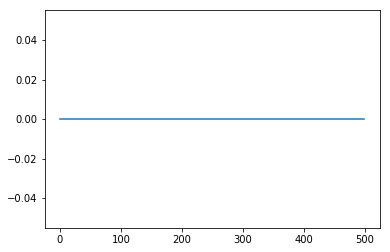

In [5]:
_list = main()
gragh(_list, len(_list))

In [3]:
# coding:utf-8
import chainer
from chainer import Function, Variable, optimizers
from chainer import Link, Chain
import chainer.functions as F
import chainer.links as L

class neuralnetwork:
    def __init__(self, num_in, num_hid1, num_hid2, num_hid3, num_out):
        self.model = Chain(hid_layer1 = L.Linear(num_in, num_hid1),
                           hid_layer2 = L.Linear(num_hid1, num_hid2),
                           hid_layer3 = L.Linear(num_hid2, num_hid3),
                           out_layer  = L.Linear(num_hid3, num_out))
        self.optimizer = optimizers.Adam()
        self.optimizer.setup(self.model)
    
    def forward(self, flg, x, t = None):
        _x = Variable(x)
        if flg == 1: _t = Variable(t)
        h1  = F.dropout(F.relu(self.model.hid_layer1(_x)))
        h2  = F.dropout(F.relu(self.model.hid_layer2(h1)))
        h3  = F.dropout(F.relu(self.model.hid_layer3(h2)))
        u3  = self.model.out_layer(h3)
        # return F.softmax_cross_entropy(u2, _t) if flg else F.softmax(u2)
        # return F.mean_squared_error(self.policy_greedy(u3), _t) if flg else u3
        return F.mean_squared_error(u3, _t) if flg else u3
    
    def backpropagation(self, loss):
        loss.backward()
        self.optimizer.update()
    
    def init_grads(self):
        self.optimizer.zero_grads()
        
    def policy_greedy(self, actions):
        return np.max(actions.data, axis = 1)

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

def gragh(result, epoch):    
    x = np.arange(0, epoch, 1)
    left = np.array(x)
    count = 0
    count_1 = 0
    parcent = []
    for i in result:
        count += 1
        if i == 1:
            count_1 += 1
        parcent.append(count_1/count)
    height = np.array(parcent)
    plt.plot(left, height)